In [3]:
# ===== Cell 1: Setup & Cek Environment =====
import os, sys
import platform
import pandas as pd
import numpy as np

# Cek versi paket penting (untuk debugging)
def version_str(pkg):
    try:
        return pkg.__version__
    except Exception:
        return "tidak tersedia"

print("Python:", platform.python_version())
print("OS:", platform.system(), platform.release())
print("pandas:", version_str(pd))
print("numpy :", version_str(np))

# Cek scikit-learn, imbalanced-learn, Sastrawi, tqdm, joblib
sklearn_v = "tidak tersedia"
imblearn_v = "tidak tersedia"
sastrawi_v = "tidak tersedia"
tqdm_v = "tidak tersedia"
joblib_v = "tidak tersedia"

try:
    import sklearn
    sklearn_v = sklearn.__version__
except:
    pass

try:
    import imblearn
    imblearn_v = imblearn.__version__
except:
    pass

try:
    import Sastrawi
    sastrawi_v = "terinstal"
except:
    pass

try:
    from tqdm import tqdm
    tqdm_v = "terinstal"
except:
    pass

try:
    import joblib
    joblib_v = joblib.__version__
except:
    pass

print("scikit-learn:", sklearn_v)
print("imbalanced-learn:", imblearn_v)
print("Sastrawi:", sastrawi_v)
print("tqdm:", tqdm_v)
print("joblib:", joblib_v)

# Tampilkan working dir dan daftar file CSV/XLSX
cwd = os.getcwd()
print("\nWorking directory:", cwd)
files = os.listdir(cwd)
csv_files = [f for f in files if f.lower().endswith((".csv",".xlsx"))]

print(f"\nJumlah file CSV/XLSX di folder: {len(csv_files)}")
for f in csv_files:
    print(" -", f)

Python: 3.12.6
OS: Windows 11
pandas: 2.1.4
numpy : 1.26.2
scikit-learn: 1.3.2
imbalanced-learn: 0.14.0
Sastrawi: terinstal
tqdm: terinstal
joblib: 1.3.2

Working directory: C:\Users\muham\Skripsi\Revisi

Jumlah file CSV/XLSX di folder: 8
 - 600 news with valid hoax label.csv
 - dataset_final_3.xlsx
 - dataset_sosmed_fix.xlsx
 - data_gabungan_final.xlsx
 - Data_latih.csv
 - politik.csv
 - turnbackhoax.csv
 - ~$dataset_final_3.xlsx


In [4]:
# ===== Cell 2a: Load Dataset Berita =====
import pandas as pd

# Load dataset (hanya text & label)
data_berita = pd.read_excel("dataset_final_3.xlsx")

# Cek struktur
print("Kolom:", data_berita.columns.tolist())
print("Ukuran dataset:", data_berita.shape)

# Pastikan tidak ada NaN
data_berita["text"] = data_berita["text"].fillna("")
data_berita["label"] = data_berita["label"].astype(int)

# Info label
print("\nDistribusi label (0=REAL, 1=HOAX):")
print(data_berita["label"].value_counts())

# Contoh data
print("\nContoh data:")
print(data_berita.sample(5))


Kolom: ['text', 'label']
Ukuran dataset: (6926, 2)

Distribusi label (0=REAL, 1=HOAX):
label
0    3463
1    3463
Name: count, dtype: int64

Contoh data:
                                                   text  label
2886  Server KPU Jawa Barat Down diserang Secara Mas...      1
4889  TEMPO.CO, Jakarta - Kepala Badan Komunikasi St...      0
3861   TAK terasa, tiga bulan lagi akan ada sejarah ...      0
6599  TEMPO.CO, Jakarta - Kepala Sekretariat Preside...      0
844   FOTO E-TICKET DENGAN NAMA RIZIEQ SHIHAB Sebuah...      1


In [5]:
# ===== Cell 2b: Load Dataset Sosmed =====
import pandas as pd

# Baca dataset sosmed (FIX)
data_sosmed = pd.read_excel("dataset_sosmed_fix.xlsx")

# Cek struktur awal
print("Kolom:", data_sosmed.columns.tolist())
print("Ukuran dataset:", data_sosmed.shape)

# Pastikan kolom sesuai
if "text" not in data_sosmed.columns:
    raise ValueError("⚠️ Tidak ada kolom 'text' di dataset sosmed")

if "label" not in data_sosmed.columns:
    raise ValueError("⚠️ Tidak ada kolom 'label' di dataset sosmed")

# Rapihin data
data_sosmed["text"] = data_sosmed["text"].fillna("")
data_sosmed["label"] = data_sosmed["label"].astype(int)

# Info dataset sosmed
print("\nDistribusi label (0=REAL, 1=HOAX):")
print(data_sosmed["label"].value_counts())

# Contoh data
print("\nContoh data sosmed:")
print(data_sosmed.sample(5))


Kolom: ['text', 'label']
Ukuran dataset: (3748, 2)

Distribusi label (0=REAL, 1=HOAX):
label
0    1874
1    1874
Name: count, dtype: int64

Contoh data sosmed:
                                                   text  label
2265  Terkait Drone China, Prabowo Mengatakan China ...      1
1491    Video “Siaran Kecurangan Pilpres TV Al Jazeera”      1
2792  Minum Air Hangat 4 Kali Sehari Dapat Menyembuh...      1
544   Komisi II DPR menolak permintaan KPU untuk kon...      0
1574  “VIDEO SHALAT BERJAMAAH SAAT PIALA DUNIA 2022 ...      1


In [56]:
# ===== Cell 3: Preprocessing Berita & Sosmed (Loader Baru + Stemming + Debias) =====
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm.auto import tqdm

print("🚀 Memuat & Preprocessing Dataset Berita + Sosmed (Anti Bias)")

# =====================================================
# FUNGSI LOAD + AUTO FIX KOLOM
# =====================================================
def load_and_fix(path):
    try:
        df = pd.read_excel(path)
    except:
        df = pd.read_excel(path, engine='openpyxl')

    for col in ['text', 'teks', 'FullText', 'content', 'narasi', 'berita', 'judul']:
        if col in df.columns:
            df.rename(columns={col: 'text'}, inplace=True)
            break

    if 'hoax' in df.columns:
        df.rename(columns={'hoax': 'label'}, inplace=True)

    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError(f"❌ Kolom tidak valid di {path}")

    return df[['text', 'label']]

# =====================================================
# 1. LOAD DATASET
# =====================================================
df_berita = load_and_fix('dataset_final_3.xlsx')
df_sosmed = load_and_fix('dataset_sosmed_fix.xlsx')

print(f"📂 Berita : {df_berita.shape}")
print(f"📂 Sosmed : {df_sosmed.shape}")

# =====================================================
# 2. STOPWORDS + BLACKLIST (ANTI BIAS)
# =====================================================
stop_factory = StopWordRemoverFactory()

base_stopwords = stop_factory.get_stop_words()

extra_stopwords = [
    # umum
    "dengan","bahwa","karena","sudah","juga","akan","untuk",
    "dan","ini","itu","atau","yang","di","ke","dari","kata","jadi","cnn",
    "ungkap","ujar","tutur","jelas","tambah","lanjut","nilai","tegas","klaim",
    "tahun","hari","bulan","kini","lalu","saat","kemarin",
    "wawancara","pernyataan","laporan","rilis","sumber"

    # sosmed
    "yg","dg","rt","dgn","sdh","aja","kalo","gak","ni","tu"
]

# 🔥 BLACKLIST HASIL BEDAH OTAK MODEL
bias_blacklist = [
    # struktural
    "baca","lihat","jadi","kata","sebut","nya","the","info","baru","orang",

    # politik shortcut
    "jokowi","presiden","partai","politik","indonesia","jakarta",
    "menteri","dpr","ketua","umum","pilih","perintah","persen",
    "anies","milu",

    # media / format
    "foto","video","tangkapan","layar","artikel","judul","narasi","halaman",

    # hoax eksplisit (hindari shortcut)
    "hoax","disinformasi","fitnah","hasut","klaim"
]

stop_words = set(base_stopwords + extra_stopwords + bias_blacklist)

# =====================================================
# 3. STEMMER + CACHE
# =====================================================
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stem_cache = {}

# =====================================================
# 4. CLEANING + STEMMING
# =====================================================
def clean_text(text):
    if pd.isna(text):
        return ""
    
    s = str(text).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-zA-Z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    
    tokens = [w for w in s.split() if w not in stop_words]

    out = []
    for w in tokens:
        if w not in stem_cache:
            stem_cache[w] = stemmer.stem(w)
        out.append(stem_cache[w])

    return " ".join(out)

# =====================================================
# 5. EKSEKUSI
# =====================================================
tqdm.pandas()

print("⏳ Preprocessing berita...")
df_berita['clean_text'] = df_berita['text'].astype(str).progress_apply(clean_text)

print("⏳ Preprocessing sosmed...")
df_sosmed['clean_text'] = df_sosmed['text'].astype(str).progress_apply(clean_text)

df_berita = df_berita[df_berita['clean_text'].str.len() > 3]
df_sosmed = df_sosmed[df_sosmed['clean_text'].str.len() > 3]

# =====================================================
# 6. CEK OUTPUT
# =====================================================
print("\n✅ PREPROCESSING SELESAI (DEBIAS AKTIF)")
print("Berita sample:")
print(df_berita[['text','clean_text','label']].head())

print("\nSosmed sample:")
print(df_sosmed[['text','clean_text','label']].head())


🚀 Memuat & Preprocessing Dataset Berita + Sosmed (Anti Bias)
📂 Berita : (6926, 2)
📂 Sosmed : (3748, 2)
⏳ Preprocessing berita...


100%|██████████████████████████████████████████████████████████████████████████████| 6926/6926 [35:25<00:00,  3.26it/s]


⏳ Preprocessing sosmed...


100%|██████████████████████████████████████████████████████████████████████████████| 3748/3748 [03:50<00:00, 16.27it/s]


✅ PREPROCESSING SELESAI (DEBIAS AKTIF)
Berita sample:
                                                text  \
0  Jakarta, CNN Indonesia -- Laksamana Yudo Margo...   
1  TEMPO.CO, Jakarta - Kegiatan Presiden Joko Wid...   
2  Jakarta, CNN Indonesia -- Ketua Dewan Pimpinan...   
3  Jakarta, CNN Indonesia -- Anggota Komisi III D...   
4  Putri Vladimir Putin Meninggal Setelah Dosis K...   

                                          clean_text  label  
0  laksamana yudo margono sempat salah ucap sumpa...      0  
1  tempo co giat joko widodo sama pimpin g taman ...      0  
2  dewan pimpin wilayah solidaritas psi dki micha...      0  
3  anggota komisi iii fraksi ppp arsul sani pasti...      0  
4  putri vladimir putin tinggal dosis dua vaksin ...      1  

Sosmed sample:
                                                text  \
0  /jdm salah satu penyebab 8LOOM GHAIB sulit com...   
1         ngapa jadi bahas politik sama kakek w inih   
2         Paus Jenis Nun Terdampar di Pantai Nunhila

In [57]:
# ===== Cell 4a: TF-IDF Berita (3-Gram) =====
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

print("🔠 TF-IDF Berita (Unigram–Bigram–Trigram)")

vectorizer_berita = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    min_df=2
)

Xb = vectorizer_berita.fit_transform(df_berita['clean_text'])
yb = df_berita['label']

# Split (80:20, stratified)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.2, random_state=42, stratify=yb
)

print("=== Dataset Berita ===")
print("Shape X_train:", Xb_train.shape)
print("Shape X_test :", Xb_test.shape)
print("Distribusi train:", yb_train.value_counts().to_dict())
print("Distribusi test :", yb_test.value_counts().to_dict())


🔠 TF-IDF Berita (Unigram–Bigram–Trigram)
=== Dataset Berita ===
Shape X_train: (5540, 20000)
Shape X_test : (1386, 20000)
Distribusi train: {1: 2770, 0: 2770}
Distribusi test : {1: 693, 0: 693}


In [58]:
# ===== Cell 4a.1: Tabel Contoh Hasil TF-IDF =====
import numpy as np
import pandas as pd
from IPython.display import display

# Ambil nama fitur (kata & bigram)
feature_names = np.array(vectorizer_berita.get_feature_names_out())

# Hitung rata-rata bobot TF-IDF tiap fitur
tfidf_mean = X_berita.mean(axis=0).A1  # konversi sparse → array 1D

# Tentukan jumlah kata yang ingin ditampilkan
top_n = 10

# Ambil indeks TF-IDF tertinggi
top_idx = np.argsort(tfidf_mean)[-top_n:][::-1]

# Buat tabel
tfidf_table = pd.DataFrame({
    "Kata / Frasa": feature_names[top_idx],
    "Nilai TF-IDF": tfidf_mean[top_idx]
})

# Tampilkan tabel (WAJIB pakai display)
display(tfidf_table)


,Kata / Frasa,Nilai TF-IDF
0,intoleransi,0.018218
1,kasus duga korupsi,0.017846
2,hotel grand,0.016326
3,jenderal demokrasi juang,0.016174
4,sedang susah,0.015725
5,partai tetap,0.015677
6,puasa,0.014991
7,jadi anggota dewan,0.014289
8,positif virus,0.013198
9,lini,0.012809


In [59]:
# ===== Cell 4b: TF-IDF Sosmed (3-Gram) =====
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

print("🔠 TF-IDF Sosmed (Unigram–Bigram–Trigram)")

vectorizer_sosmed = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    min_df=2
)

Xs = vectorizer_sosmed.fit_transform(df_sosmed['clean_text'])
ys = df_sosmed['label']

# Split (80:20, stratified)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, ys, test_size=0.2, random_state=42, stratify=ys
)

print("=== Dataset Sosmed ===")
print("Shape Xs_train:", Xs_train.shape)
print("Shape Xs_test :", Xs_test.shape)
print("Distribusi train:", ys_train.value_counts().to_dict())
print("Distribusi test :", ys_test.value_counts().to_dict())


🔠 TF-IDF Sosmed (Unigram–Bigram–Trigram)
=== Dataset Sosmed ===
Shape Xs_train: (2997, 7835)
Shape Xs_test : (750, 7835)
Distribusi train: {0: 1499, 1: 1498}
Distribusi test : {1: 375, 0: 375}


In [60]:
# ===== Cell 4b.1: Tabel Contoh Hasil TF-IDF Sosmed =====
import numpy as np
import pandas as pd
from IPython.display import display

# Ambil nama fitur
feature_names_sosmed = np.array(vectorizer_sosmed.get_feature_names_out())

# HITUNG DARI DATA TRAIN (INI PENTING)
tfidf_mean_sosmed = Xs_train.mean(axis=0).A1

# Jumlah kata/frasa ditampilkan
top_n = 10

# Ambil indeks TF-IDF tertinggi
top_idx_sosmed = np.argsort(tfidf_mean_sosmed)[-top_n:][::-1]

# Buat tabel
tfidf_table_sosmed = pd.DataFrame({
    "Kata / Frasa": feature_names_sosmed[top_idx_sosmed],
    "Nilai TF-IDF": tfidf_mean_sosmed[top_idx_sosmed]
})

display(tfidf_table_sosmed)


,Kata / Frasa,Nilai TF-IDF
0,gue,0.029765
1,yg,0.014632
2,sama,0.009177
3,semua,0.008694
4,ga,0.008600
5,prabowo,0.008488
6,buat,0.008399
7,covid,0.007415
8,dukung,0.007413
9,jadi,0.007403


In [61]:
# ===== Cell 5a: Training Multinomial Naive Bayes (Berita) =====
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("🚀 Training Multinomial Naive Bayes - Berita")

# Inisialisasi model
mnb_berita = MultinomialNB()

# Training
mnb_berita.fit(Xb_train, yb_train)

# Prediksi
yb_pred = mnb_berita.predict(Xb_test)

# Evaluasi
print("\n=== Evaluasi Model (MNB - Berita) ===")
print("Akurasi:", accuracy_score(yb_test, yb_pred))
print("\nClassification Report:")
print(classification_report(yb_test, yb_pred, target_names=["REAL", "HOAX"]))
print("\nConfusion Matrix:")
print(confusion_matrix(yb_test, yb_pred))


🚀 Training Multinomial Naive Bayes - Berita

=== Evaluasi Model (MNB - Berita) ===
Akurasi: 0.9466089466089466

Classification Report:
              precision    recall  f1-score   support

        REAL       0.93      0.96      0.95       693
        HOAX       0.96      0.93      0.95       693

    accuracy                           0.95      1386
   macro avg       0.95      0.95      0.95      1386
weighted avg       0.95      0.95      0.95      1386


Confusion Matrix:
[[668  25]
 [ 49 644]]


In [62]:
# ===== Cell 5b: Training Multinomial Naive Bayes (Sosmed) =====
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("🚀 Training Multinomial Naive Bayes - Sosmed")

# Inisialisasi model
mnb_sosmed = MultinomialNB()

# Training
mnb_sosmed.fit(Xs_train, ys_train)

# Prediksi
ys_pred = mnb_sosmed.predict(Xs_test)

# Evaluasi
print("\n=== Evaluasi Model (MNB - Sosmed) ===")
print("Akurasi:", accuracy_score(ys_test, ys_pred))
print("\nClassification Report:")
print(classification_report(ys_test, ys_pred, target_names=["REAL", "HOAX"]))
print("\nConfusion Matrix:")
print(confusion_matrix(ys_test, ys_pred))


🚀 Training Multinomial Naive Bayes - Sosmed

=== Evaluasi Model (MNB - Sosmed) ===
Akurasi: 0.9293333333333333

Classification Report:
              precision    recall  f1-score   support

        REAL       0.94      0.92      0.93       375
        HOAX       0.92      0.94      0.93       375

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750


Confusion Matrix:
[[346  29]
 [ 24 351]]


<Figure size 640x480 with 0 Axes>

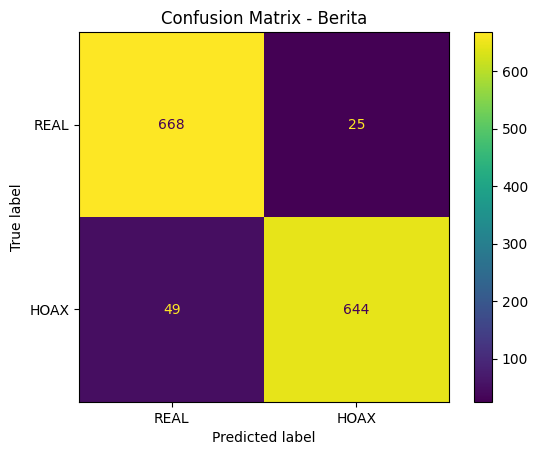

<Figure size 640x480 with 0 Axes>

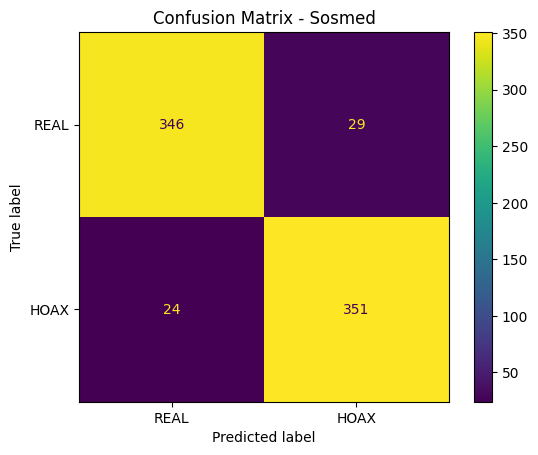

In [63]:
# ===== Cell 6: Visualisasi Confusion Matrix =====
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# -------------------------------------------------
# Confusion Matrix BERITA
# -------------------------------------------------
cm_berita = confusion_matrix(yb_test, yb_pred)

disp_berita = ConfusionMatrixDisplay(
    confusion_matrix=cm_berita,
    display_labels=["REAL", "HOAX"]
)

plt.figure()
disp_berita.plot()
plt.title("Confusion Matrix - Berita")
plt.show()

# -------------------------------------------------
# Confusion Matrix SOSMED
# -------------------------------------------------
cm_sosmed = confusion_matrix(ys_test, ys_pred)

disp_sosmed = ConfusionMatrixDisplay(
    confusion_matrix=cm_sosmed,
    display_labels=["REAL", "HOAX"]
)

plt.figure()
disp_sosmed.plot()
plt.title("Confusion Matrix - Sosmed")
plt.show()


In [64]:
# ===== Cell 6.1: Bedah Otak Model (Feature Importance - Berita) =====
import numpy as np
import pandas as pd

print("🧠 ANALISIS FEATURE IMPORTANCE - MODEL BERITA")

# Ambil fitur dari vectorizer BERITA
feature_names = vectorizer_berita.get_feature_names_out()

# Bobot log-prob dari model BERITA
log_prob = mnb_berita.feature_log_prob_

def get_top_features(class_label, n=20):
    top_indices = np.argsort(log_prob[class_label])[::-1][:n]
    return feature_names[top_indices]

print("\n✅ TOP 20 KATA DOMINAN - BERITA REAL (0):")
print(get_top_features(0))

print("\n🚨 TOP 20 KATA DOMINAN - BERITA HOAX (1):")
print(get_top_features(1))


🧠 ANALISIS FEATURE IMPORTANCE - MODEL BERITA

✅ TOP 20 KATA DOMINAN - BERITA REAL (0):
['sebut' 'milu' 'jadi' 'kata' 'pilih' 'koalisi' 'perintah' 'nasdem'
 'calon' 'prabowo' 'sama' 'laku' 'satu' 'pdip' 'tak' 'capres' 'ganjar'
 'dukung' 'demokrat' 'jabat']

🚨 TOP 20 KATA DOMINAN - BERITA HOAX (1):
['yg' 'corona' 'virus' 'china' 'covid' 'anak' 'tinggal' 'virus corona'
 'pki' 'hati' 'islam' 'jadi' 'ahok' 'mati' 'prabowo' 'buat' 'in' 'polisi'
 'warga' 'nyata']


In [65]:
# ===== Cell 7: Ringkasan Evaluasi Model =====
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -------------------------------------------------
# Evaluasi BERITA
# -------------------------------------------------
acc_b = accuracy_score(yb_test, yb_pred)
prec_b = precision_score(yb_test, yb_pred)
rec_b = recall_score(yb_test, yb_pred)
f1_b = f1_score(yb_test, yb_pred)

# -------------------------------------------------
# Evaluasi SOSMED
# -------------------------------------------------
acc_s = accuracy_score(ys_test, ys_pred)
prec_s = precision_score(ys_test, ys_pred)
rec_s = recall_score(ys_test, ys_pred)
f1_s = f1_score(ys_test, ys_pred)

# -------------------------------------------------
# Buat tabel ringkasan
# -------------------------------------------------
eval_table = pd.DataFrame({
    "Dataset": ["Berita", "Sosial Media"],
    "Accuracy": [acc_b, acc_s],
    "Precision": [prec_b, prec_s],
    "Recall": [rec_b, rec_s],
    "F1-Score": [f1_b, f1_s]
})

eval_table


,Dataset,Accuracy,Precision,Recall,F1-Score
0,Berita,0.946609,0.962631,0.929293,0.945668
1,Sosial Media,0.929333,0.923684,0.936000,0.929801


In [68]:
# ===== Cell 8: Cross Validation (Stratified 10-Fold) =====
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd

print("🔄 Menjalankan Stratified 10-Fold Cross Validation...")

# =========================================
# BERITA
# =========================================
mnb_cv_berita = MultinomialNB()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores_berita = cross_val_score(
    mnb_cv_berita,
    Xb,     # FULL FEATURE BERITA
    yb,     # FULL LABEL BERITA
    cv=skf,
    scoring='accuracy'
)

# =========================================
# SOSMED
# =========================================
mnb_cv_sosmed = MultinomialNB()

scores_sosmed = cross_val_score(
    mnb_cv_sosmed,
    Xs,     # FULL FEATURE SOSMED
    ys,     # FULL LABEL SOSMED
    cv=skf,
    scoring='accuracy'
)

# =========================================
# RINGKASAN
# =========================================
cv_table = pd.DataFrame({
    "Dataset": ["Berita", "Sosial Media"],
    "CV Mean Accuracy": [scores_berita.mean(), scores_sosmed.mean()],
    "CV Std (Stabilitas)": [scores_berita.std(), scores_sosmed.std()]
})

print("\n📊 HASIL CROSS VALIDATION")
cv_table


🔄 Menjalankan Stratified 10-Fold Cross Validation...

📊 HASIL CROSS VALIDATION


,Dataset,CV Mean Accuracy,CV Std (Stabilitas)
0,Berita,0.935169,0.009605
1,Sosial Media,0.926597,0.018366


📊 Membuat Boxplot Hasil Cross Validation...


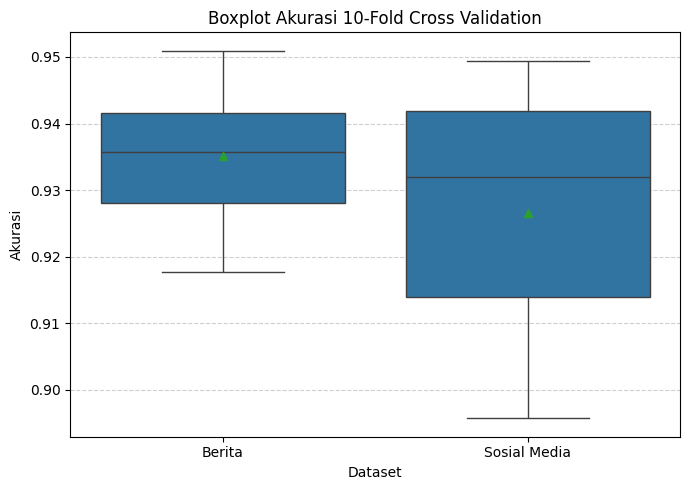

✅ Boxplot berhasil dibuat.


In [69]:
# ===== Cell 9: Boxplot Cross Validation =====
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Membuat Boxplot Hasil Cross Validation...")

# Gabungkan skor CV ke DataFrame
cv_df = pd.DataFrame({
    "Akurasi": list(scores_berita) + list(scores_sosmed),
    "Dataset": ["Berita"] * len(scores_berita) + ["Sosial Media"] * len(scores_sosmed)
})

# Plot boxplot
plt.figure(figsize=(7,5))
sns.boxplot(
    x="Dataset",
    y="Akurasi",
    data=cv_df,
    showmeans=True
)

plt.title("Boxplot Akurasi 10-Fold Cross Validation")
plt.ylabel("Akurasi")
plt.xlabel("Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("✅ Boxplot berhasil dibuat.")


📈 Membuat Learning Curve Gabungan (Berita & Sosial Media)...


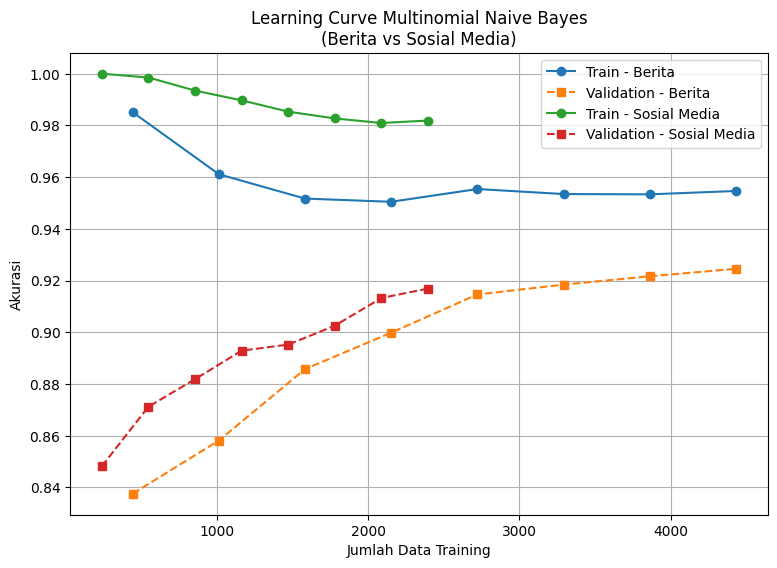

In [70]:
# ===== Cell 10: Learning Curve (Berita vs Sosial Media) =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

print("📈 Membuat Learning Curve Gabungan (Berita & Sosial Media)...")

model = MultinomialNB()

# =========================
# LEARNING CURVE - BERITA
# =========================
train_sizes_b, train_scores_b, test_scores_b = learning_curve(
    model,
    Xb_train,
    yb_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean_b = train_scores_b.mean(axis=1)
test_mean_b  = test_scores_b.mean(axis=1)

# =========================
# LEARNING CURVE - SOSMED
# =========================
train_sizes_s, train_scores_s, test_scores_s = learning_curve(
    model,
    Xs_train,
    ys_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean_s = train_scores_s.mean(axis=1)
test_mean_s  = test_scores_s.mean(axis=1)

# =========================
# PLOT GABUNGAN
# =========================
plt.figure(figsize=(9,6))

plt.plot(train_sizes_b, train_mean_b, 'o-', label='Train - Berita')
plt.plot(train_sizes_b, test_mean_b, 's--', label='Validation - Berita')

plt.plot(train_sizes_s, train_mean_s, 'o-', label='Train - Sosial Media')
plt.plot(train_sizes_s, test_mean_s, 's--', label='Validation - Sosial Media')

plt.title("Learning Curve Multinomial Naive Bayes\n(Berita vs Sosial Media)")
plt.xlabel("Jumlah Data Training")
plt.ylabel("Akurasi")
plt.legend()
plt.grid(True)
plt.show()


📊 MENCARI THRESHOLD OPTIMAL - MODEL BERITA
   Threshold  Precision    Recall  F1-Score
0        0.1   0.861423  0.995671  0.923695
1        0.2   0.903694  0.988456  0.944176
2        0.3   0.928571  0.975469  0.951443
3        0.4   0.948424  0.955267  0.951833
4        0.5   0.962631  0.929293  0.945668
5        0.6   0.977707  0.886003  0.929599
6        0.7   0.984266  0.812410  0.890119
7        0.8   0.987500  0.683983  0.808184
8        0.9   0.986622  0.425685  0.594758


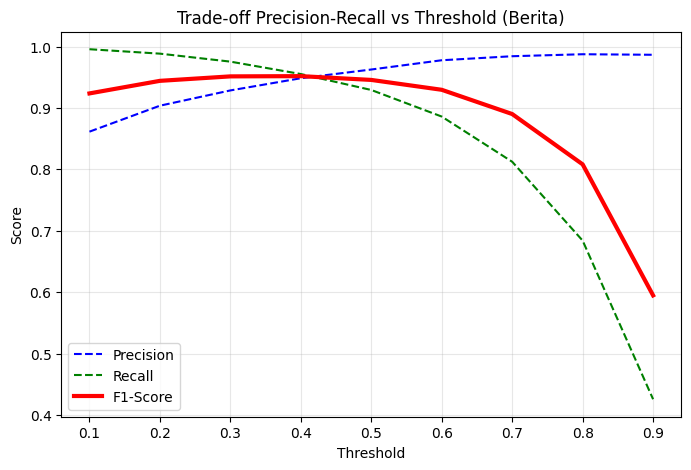

💡 Threshold Terbaik Berita: 0.4 (F1-Score: 0.9518)


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

print("📊 MENCARI THRESHOLD OPTIMAL - MODEL BERITA")

# 1. Ambil Probabilitas Hoax (Kelas 1)
yb_probs = mnb_berita.predict_proba(Xb_test)[:, 1]

# 2. List Threshold yang diuji
thresholds = np.arange(0.1, 1.0, 0.1)
results_b = []

for t in thresholds:
    yb_pred_t = (yb_probs >= t).astype(int)
    results_b.append({
        'Threshold': round(t, 1),
        'Precision': precision_score(yb_test, yb_pred_t, zero_division=0),
        'Recall': recall_score(yb_test, yb_pred_t, zero_division=0),
        'F1-Score': f1_score(yb_test, yb_pred_t, zero_division=0)
    })

df_res_b = pd.DataFrame(results_b)
print(df_res_b)

# 3. Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(df_res_b['Threshold'], df_res_b['Precision'], 'b--', label='Precision')
plt.plot(df_res_b['Threshold'], df_res_b['Recall'], 'g--', label='Recall')
plt.plot(df_res_b['Threshold'], df_res_b['F1-Score'], 'r-', linewidth=3, label='F1-Score')
plt.title('Trade-off Precision-Recall vs Threshold (Berita)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

opt_b = df_res_b.loc[df_res_b['F1-Score'].idxmax()]
print(f"💡 Threshold Terbaik Berita: {opt_b['Threshold']} (F1-Score: {opt_b['F1-Score']:.4f})")

📊 MENCARI THRESHOLD OPTIMAL - MODEL SOSMED
   Threshold  Precision    Recall  F1-Score
0        0.1   0.656743  1.000000  0.792812
1        0.2   0.746507  0.997333  0.853881
2        0.3   0.817982  0.994667  0.897714
3        0.4   0.888350  0.976000  0.930114
4        0.5   0.923684  0.936000  0.929801
5        0.6   0.963303  0.840000  0.897436
6        0.7   0.978339  0.722667  0.831288
7        0.8   0.994709  0.501333  0.666667
8        0.9   1.000000  0.178667  0.303167


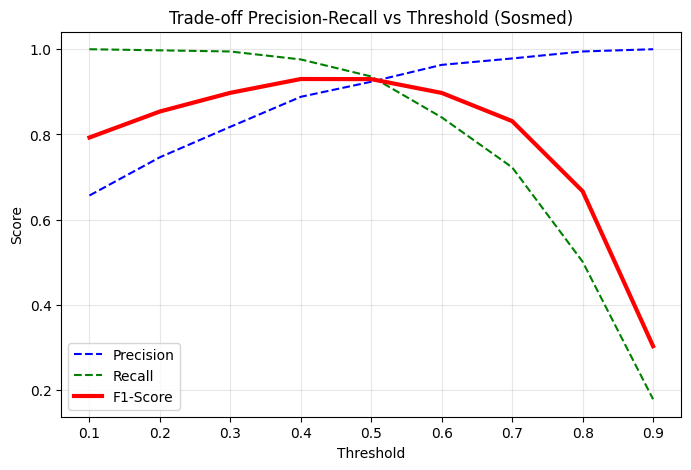

💡 Threshold Terbaik Sosmed: 0.4 (F1-Score: 0.9301)


In [86]:
print("📊 MENCARI THRESHOLD OPTIMAL - MODEL SOSMED")

# 1. Ambil Probabilitas Hoax (Kelas 1)
ys_probs = mnb_sosmed.predict_proba(Xs_test)[:, 1]

# 2. List Threshold
results_s = []

for t in thresholds:
    ys_pred_t = (ys_probs >= t).astype(int)
    results_s.append({
        'Threshold': round(t, 1),
        'Precision': precision_score(ys_test, ys_pred_t, zero_division=0),
        'Recall': recall_score(ys_test, ys_pred_t, zero_division=0),
        'F1-Score': f1_score(ys_test, ys_pred_t, zero_division=0)
    })

df_res_s = pd.DataFrame(results_s)
print(df_res_s)

# 3. Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(df_res_s['Threshold'], df_res_s['Precision'], 'b--', label='Precision')
plt.plot(df_res_s['Threshold'], df_res_s['Recall'], 'g--', label='Recall')
plt.plot(df_res_s['Threshold'], df_res_s['F1-Score'], 'r-', linewidth=3, label='F1-Score')
plt.title('Trade-off Precision-Recall vs Threshold (Sosmed)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

opt_s = df_res_s.loc[df_res_s['F1-Score'].idxmax()]
print(f"💡 Threshold Terbaik Sosmed: {opt_s['Threshold']} (F1-Score: {opt_s['F1-Score']:.4f})")

In [80]:
# ===== Cell 11: PLAYGROUND (Tes Berita Manual) =====
import re
import numpy as np

print("📰 SELAMAT DATANG DI DETEKTOR HOAX BERITA!")
print("Ketik 'keluar' kalau mau berhenti.")
print("-" * 55)

# Cleaning khusus berita (lebih formal)
def clean_text_berita(text):
    if not isinstance(text, str):
        return ""
    s = text.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-zA-Z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Threshold berita (lebih ketat)
HOAX_THRESHOLD = 0.60

while True:
    print("\n📝 Masukkan Judul / Narasi Berita:")
    user_input = input(">> ")

    if user_input.lower() in ["keluar", "exit", "quit"]:
        print("👋 Dadah bre, semoga skripsinya ACC!")
        break

    if len(user_input) < 15:
        print("⚠️ Berita kependekan bre, masukin judul + narasi dikit.")
        continue

    try:
        # 1. Cleaning
        clean_input = clean_text_berita(user_input)

        # 2. Vectorizing
        input_vec = vectorizer_berita.transform([clean_input])

        # 3. Probabilitas
        proba = mnb_berita.predict_proba(input_vec)[0]
        prob_real = proba[0]
        prob_hoax = proba[1]

        # 4. Threshold decision
        if prob_hoax >= HOAX_THRESHOLD:
            label = "🚨 HOAX"
        else:
            label = "✅ REAL"

        # 5. Output
        print("\n🔍 HASIL ANALISIS BERITA:")
        print("-" * 35)
        print(f"Kesimpulan        : {label}")
        print(f"Probabilitas REAL : {prob_real*100:.2f}%")
        print(f"Probabilitas HOAX : {prob_hoax*100:.2f}%")
        print("-" * 35)

        # 6. Kata dikenali model
        words_found = [
            w for w in clean_input.split()
            if w in vectorizer_berita.vocabulary_
        ]
        print(f"ℹ️ Kata dikenali model: {words_found}")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("   Pastikan Cell training berita sudah dijalankan!")


📰 SELAMAT DATANG DI DETEKTOR HOAX BERITA!
Ketik 'keluar' kalau mau berhenti.
-------------------------------------------------------

📝 Masukkan Judul / Narasi Berita:


>>  Hanya saja, kata dia, jika Ali benar-benar tertarik dan ingin bergabung ke kubunya, maka PAN akan menerima dan menyiapkan karpet biru untuk. "Kalau kemudian beliau tertarik dan berminat berlabuh ke PAN, kami siapkan karpet biru, welcome, ahlan wa sahlan (selat datang). Tapi saya belum bisa memastikan," ujarnya.. Sementara soal Anak La Nyalla, yakni Ali Affandi Mattaliti, Rizki mengaku dirinya belum sempat bertemu dan komunikasi. Tapi ia mempersilakan jika Affandi ingin bergabung ke PAN. "Mas Andi (Ali Affandi) belum. Prinsipnya saya undang seluruh anak bangsa, kalangan milenial, seluruh elemen masyarakat, bahwa PAN adalah rumah besar bagi semua golongan. Kalau kata ketum kita, PAN menyinari semua lapisan masyarakat dan kita buka peluang sebesar-besarnya," kata dia. Sementara itu, Kepala Badan Pembina Organisasi, Kaderisasi, dan Keanggotaan (BPOKK) DPD Demokrat Jawa Timur, Mugianto, menyatakan Ali dan Affandi tetap setia dan loyal pada Demokrat. Ini menepis kabar kedua kader Demokra


🔍 HASIL ANALISIS BERITA:
-----------------------------------
Kesimpulan        : ✅ REAL
Probabilitas REAL : 88.90%
Probabilitas HOAX : 11.10%
-----------------------------------
ℹ️ Kata dikenali model: ['hanya', 'kata', 'dia', 'ali', 'benar', 'benar', 'dan', 'ingin', 'pan', 'akan', 'dan', 'karpet', 'biru', 'untuk', 'kalau', 'kemudian', 'beliau', 'dan', 'pan', 'karpet', 'biru', 'welcome', 'wa', 'selat', 'datang', 'belum', 'bisa', 'soal', 'anak', 'la', 'nyalla', 'ali', 'rizki', 'belum', 'sempat', 'dan', 'komunikasi', 'ingin', 'pan', 'mas', 'andi', 'ali', 'belum', 'undang', 'seluruh', 'anak', 'bangsa', 'milenial', 'seluruh', 'elemen', 'masyarakat', 'pan', 'rumah', 'besar', 'bagi', 'semua', 'kalau', 'kata', 'pan', 'semua', 'masyarakat', 'dan', 'buka', 'peluang', 'kata', 'dia', 'itu', 'kepala', 'badan', 'organisasi', 'kaderisasi', 'dan', 'bpokk', 'dpd', 'demokrat', 'jawa', 'timur', 'ali', 'dan', 'tetap', 'setia', 'dan', 'loyal', 'pada', 'demokrat', 'ini', 'kabar', 'kader', 'demokrat', 'itu

>>  keluar


👋 Dadah bre, semoga skripsinya ACC!


In [83]:
# ===== Cell 11: PLAYGROUND (Tes Sosial Media Manual) =====
import re
import numpy as np

print("📱 SELAMAT DATANG DI DETEKTOR HOAX SOSIAL MEDIA!")
print("Ketik 'keluar' kalau mau berhenti.")
print("-" * 55)

# Cleaning khusus sosmed (tanpa stemming)
def clean_text_sosmed(text):
    if not isinstance(text, str):
        return ""
    s = text.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"@\w+|#\w+", " ", s)   # hapus mention & hashtag
    s = re.sub(r"[^a-zA-Z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Threshold biar ga hoax mulu
HOAX_THRESHOLD = 0.5

while True:
    print("\n📝 Masukkan Caption / Postingan Sosmed:")
    user_input = input(">> ")

    if user_input.lower() in ["keluar", "exit", "quit"]:
        print("👋 Dadah bre, semoga sidangnya lancar!")
        break

    if len(user_input) < 10:
        print("⚠️ Kependekan bre, masukin caption yang agak panjang.")
        continue

    try:
        # 1. Cleaning
        clean_input = clean_text_sosmed(user_input)

        # 2. Vectorizing
        input_vec = vectorizer_sosmed.transform([clean_input])

        # 3. Prediksi probabilitas
        proba = mnb_sosmed.predict_proba(input_vec)[0]
        prob_real = proba[0]
        prob_hoax = proba[1]

        # 4. Threshold decision
        if prob_hoax >= HOAX_THRESHOLD:
            label = "🚨 HOAX"
        else:
            label = "✅ REAL"

        # 5. Output
        print("\n🔍 HASIL ANALISIS SOSMED:")
        print("-" * 35)
        print(f"Kesimpulan        : {label}")
        print(f"Probabilitas REAL : {prob_real*100:.2f}%")
        print(f"Probabilitas HOAX : {prob_hoax*100:.2f}%")
        print("-" * 35)

        # 6. Kata yang dikenali model
        words_found = [
            w for w in clean_input.split()
            if w in vectorizer_sosmed.vocabulary_
        ]
        print(f"ℹ️ Kata dikenali model: {words_found}")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("   Pastikan model & vectorizer sosmed sudah ditraining!")


📱 SELAMAT DATANG DI DETEKTOR HOAX SOSIAL MEDIA!
Ketik 'keluar' kalau mau berhenti.
-------------------------------------------------------

📝 Masukkan Caption / Postingan Sosmed:


>>  Hidayat Nur Wahid Akui PKS Tak Menganut Asas Pancasila Kalau kita perhatikan ideologi PKS secara universal sama seperti PKI, karena mereka memiliki Jaringan luar Negeri yang di anut sehingga bertolak belakang dengan Ideologi Pancasila.



🔍 HASIL ANALISIS SOSMED:
-----------------------------------
Kesimpulan        : 🚨 HOAX
Probabilitas REAL : 38.65%
Probabilitas HOAX : 61.35%
-----------------------------------
ℹ️ Kata dikenali model: ['wahid', 'pks', 'tak', 'asas', 'pancasila', 'kalau', 'ideologi', 'pks', 'sama', 'seperti', 'pki', 'luar', 'negeri', 'anut', 'belakang', 'ideologi', 'pancasila']

📝 Masukkan Caption / Postingan Sosmed:


>>  kalo fyp tiktok tentang politik gue udah paling males sbnrnya buka comment section krna isinya modelan gini semua wkwkwk Gmn negara mau maju kalo rakyatnya aja bilang indo ga butuh kampus



🔍 HASIL ANALISIS SOSMED:
-----------------------------------
Kesimpulan        : ✅ REAL
Probabilitas REAL : 99.01%
Probabilitas HOAX : 0.99%
-----------------------------------
ℹ️ Kata dikenali model: ['fyp', 'tiktok', 'tentang', 'politik', 'gue', 'udah', 'paling', 'males', 'sbnrnya', 'buka', 'krna', 'semua', 'wkwkwk', 'gmn', 'negara', 'mau', 'maju', 'aja', 'bilang', 'indo', 'ga', 'butuh', 'kampus']

📝 Masukkan Caption / Postingan Sosmed:


>>  keluar


👋 Dadah bre, semoga sidangnya lancar!


In [84]:
# ===== Cell FINAL: Simpan Model Berita & Sosmed =====
import pickle

# BERITA
with open("model_berita.pkl", "wb") as f:
    pickle.dump(mnb_berita, f)

with open("vectorizer_berita.pkl", "wb") as f:
    pickle.dump(vectorizer_berita, f)

# SOSMED
with open("model_sosmed.pkl", "wb") as f:
    pickle.dump(mnb_sosmed, f)

with open("vectorizer_sosmed.pkl", "wb") as f:
    pickle.dump(vectorizer_sosmed, f)

print("✅ Semua model & vectorizer berhasil disimpan")


✅ Semua model & vectorizer berhasil disimpan
